In [114]:
# Design of a Parabolic Nozzle for HALE Rocket 
# Optimization of Final Altitude, Staying [Above] [Below] 2nd Critical Point
# Assume isentropic flow between normal shocks: all losses in nozzle occure across the normal shock

# Author: Jacob van de Lindt 
# August 2019

In [115]:
# Imports and Definitions of constants and knows 

# Imports
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

# Constants 
k = 1.226 # Cp/Cv for HALE Kerosene/Oxygen Mixture Ratio
Rbar = 8314 # [J/K-mol] universal gas constant
R = 389.4145 # [J/kgK] for the fuel/oxidizer mixture
R_air = 287.05287 # [J/kgK] for dry air
g_c = 1 # [m/s^2]
g_0 = 9.81 # [m/s^2] gravitational constant at sea level
A_c = np.pi * (0.1524/2)**2 # [m^2] cross sectional area of HALE Rocket (6 inch D)
wet_mass = 68.0389 # [kg]
# Knowns 
m_dot = 3.5017  # mass flow rate, [kg/s]. Assumed constant

# Knowns at station 1, inside combustion chamber 
M_1 = 0
T_1 = 3600 # [K] adiabatic flame temperature 
P_1 = 2.413e6 # [Pa] chamber pressure 
D_1 = 0.1397 # [m] The combustion chamber diameter 
A_1 = (1/4)*np.pi*D_1**2 # [m^2]
# Define first stagnation conditions (from combustion chamber to shock) as station 1 knowns 
T_t1 = T_1
P_t1 = P_1

In [116]:
print(A_c)

0.01824146924750992


In [117]:
# Define environment conditions at altitude 
def g_grav(alt):
    # Takes an altitude in meters and returns the gravitation acceleration  
    G = 6.674*10**(-11) # m^3 / (kg s^2)
    M_earth = 5.972e24 # kg
    r_earth = 6371000 # km
    return G * M_earth / (alt + r_earth)**2 

def T_at_alt(alt):
    # Enter an altitude in [m] and it will output the temperature in [K] at this alt 
    alt_km = alt / 1000 # convert to [Km]
    # Use conditionals for lapse rates. 
    # Values from https://www.translatorscafe.com/unit-converter/en-US/calculator/altitude/
    
    if alt_km < 11:
        L_b = -6.5
        T_b = 288.15  # [K]
        alt_b = 0 # [km]
    elif alt_km < 20:
        L_b = 0
        T_b = 216.65  # [K]
        alt_b = 11 # [km]
    elif alt_km < 32:
        L_b = 1
        T_b = 216.65  # [K]
        alt_b = 20 # [km]
    elif alt_km < 47:
        L_b = 2.8
        T_b = 228.65  # [K]
        alt_b = 32 # [km]
    elif alt_km < 51:
        L_b = 0
        T_b = 270.65  # [K]
        alt_b = 47 # [km]
    elif alt_km < 71:
        L_b = -2.8
        T_b = 270.65  # [K]
        alt_b = 51 # [km]
    elif alt_km <= 84.9:
        L_b = -2
        T_b = 214.65 # [K]
        alt_b = 71 # [km]
    else:
        return('Error: Atmosphere Air Temp Not Valid Beyond 84.9 km')
    T_alt = T_b + L_b*(alt_km - alt_b)
    return T_alt 
# vectorize the function for use with numpy arrays  
v_T_at_alt = np.vectorize(T_at_alt)

def P_at_alt(alt):
# Enter an altitude in [m] and it will output the pressure in [Pa] at this alt 
    alt_km = alt / 1000 # convert to [Km]
    # Use conditionals for lapse rates. 
    # Values from https://www.translatorscafe.com/unit-converter/en-US/calculator/altitude/
    if alt_km < 11:
        L_b = -6.5
        T_b = 288.15  # [K]
        alt_b = 0 # [km]
        P_b = 101325 # [Pa]
    elif alt_km < 20:
        L_b = 0
        T_b = 216.65  # [K]
        alt_b = 11 # [km]
        P_b = 22632.06 # [Pa] 
    elif alt_km < 32:
        L_b = 1
        T_b = 216.65  # [K]
        alt_b = 20 # [km]
        P_b = 5474.889 # [Pa]
    elif alt_km < 47:
        L_b = 2.8
        T_b = 228.65  # [K]
        alt_b = 32 # [km]
        P_b = 868.0187 # [Pa]
    elif alt_km < 51:
        L_b = 0
        T_b = 270.65  # [K]
        alt_b = 47 # [km]
        P_b = 110.9063 # [Pa]
    elif alt_km < 71:
        L_b = -2.8
        T_b = 270.65  # [K]
        alt_b = 51 # [km]
        P_b = 66.93887 # [Pa]
    elif alt_km <= 84.9:
        L_b = -2
        T_b = 214.65 # [K]
        alt_b = 71 # [km]
        P_b = 3.956420 # [Pa]
    else:
        return 'error'
    if L_b != 0:
        L_b_per_m = L_b / 1000 # convert to [K/m]
        base = T_b / v_T_at_alt(alt)
        exponant = g_0 / (R_air * L_b_per_m)
        P_alt = P_b * base**exponant
    else:
        exponant = (g_0 * (alt - alt_b*1000)) / (R_air * T_b)
        P_alt = P_b * np.exp(-exponant)
    return P_alt
    # Enter an altitude in [m] and it will return the pressure at this altitude in [Pa]
    # Can be used up to 86 Alt = Km. 
    
# vectorize the function for use with numpy arrays  
v_P_at_alt = np.vectorize(P_at_alt)    

def density_at_alt(alt):
    # Use existing pressure and temp functions along with eq of state for a perfect gas
    if alt <= 84900:   #[m]
        return v_P_at_alt(alt) / (R_air * v_T_at_alt(alt))
    else:
        return alt*0

# vectorize the function for use with numpy arrays  
v_density_at_alt = np.vectorize(density_at_alt) 

In [118]:
# Define Isentropic Relations and Normal Shock Property Changes

def T_over_T_stag(M, k):
    return ( 1 + ((k - 1) / 2)*M**2 )**(-1)

def A_over_A_star(M, k):
    # Isentropic Relation (Eq. (5.37) GDB) 
    # Takes in the mach number and heat capacity ratio and returns the area ratio
    term_1 = 1 / M
    numerator = 1 + ( (k - 1) / 2)*M**2
    denominator = ( k + 1) / 2
    term_2 = numerator / denominator
    power = ( k + 1 ) / (2*(k - 1))
    return term_1 * term_2**power

def p_over_p_stag(M, k):
    # Isentropic Relation (Eq. (5.40) GDB) 
    # Takes in the mach number and heat capacity ratio and returns the pressure ratio
    # p / p_stagnation 
    base = 1 / (1 + ( (k - 1) / 2)*M**2 )
    power = k / (k - 1)
    return base**power

# The next two functions are used to determine the mach number at a station if the
# stagnation pressure vs. stagnation pressure ratio and area ration are known. Iteration is used. 
# The initial mach number guess must be in the correct regiem (supersonic or subsonic)

def get_M_helper_1(M_guess, A_P_ratio, k):
    # M_guess is the guessed mach number, must be in correct mach regiem
    # A_P_ratio is A/A* times p/p_stagnation 
    C = (k+1)/2
    D = (k-1)/2
    J = (k+1)/(2*k-2)
    W = k/(k-1)
    return (1/A_P_ratio) * (( (1 + D*M_guess**2)/C )**J) * ((1 / (1 + D*M_guess**2))**W)

def get_M_given_Ar_Pr(M_guess, A_P_ratio, k):
    # Uses get_M_helper_1 to solve for the mach number with iteration given the product of
    # area and pressure ratios at the station, as well as k and an initial guess for the mach number.
    M = M_guess
    
    # interate for M 
    for i in range(40):
        # It was found that 40 iterations more than insured convergance 
        M = get_M_helper_1(M, A_P_ratio, k)
    return M

# The next two functions accomplish the same outcome as the last two: iteration is used
# to solve for the mach number. However, this set only requiers the stagnation pressure
# ratio, as well as k and a guess for M as inputs. 

def get_M_helper_2(M_guess, Pr, k):
    # Returns an estimation for mach number given a guess for mach number, the pressure
    # ratio, and the heat capacity ratio 
    
    # define exponants and factors 
    X = (k+1)/2
    Y = (k-1)/2
    N = k/(k-1)
    T = (2*k)/(k+1)
    Z = (k-1)/(k+1)
    L = 1/(1-k)
    M = M_guess
    inside = (M**2 * X) / (M**2 * Y + 1)
    inside_raised = ( Pr * inside**(-N) ) ** (1/L)
    return np.sqrt( (inside_raised + Z) / T)

def get_M_given_P_t_ratio(M_guess, P_t_ratio, k):
    # Interate to solve for the mach number given the stagnation pressure ratio
    # across the shock. returns the mach number just before the shock  
    M = M_guess
    
    # iterate and solve for M. 40 iterations was found to have good convergance 
    for i in range(40):
        M = get_M_helper_2(M, P_t_ratio, k)
    return M


# This next set uses iteration and the area ratio to solve for the mach number.
# It is only valid for isentropic flow, and for M > 1. 

def get_M_helper_3(M_new, A_r, k):
    term_1 = M_new * A_r
    C = (k+1)/2
    D = (k-1)/2
    J = (k+1)/(2*k-2)
    term_2 = (term_1 ** (1/J) ) * C - 1
    return np.sqrt( term_2 / D )


def get_M_given_A_r(M_guess, A_r, k):
    M = M_guess
    for i in range(40):
        M = get_M_helper_3(M, A_r, k)
    return M

# Next function returns an area [m^2] given the mach number and stagnation conditions
# For Isentropic flow, Equation (5.44a) GDB
def A_given_M(M, T_t, P_t):
    first = m_dot / M
    power = (k + 1) / (2*(k - 1))
    second = (1 + ( (k - 1)/2 ) * M**2 ) ** (power)
    third = (R / (k*g_c)) ** (1/2)
    fourth = np.sqrt(T_t) / P_t
    
    return first*second*third*fourth

In [119]:
# Define Thrust and Drag Force Functions 

def F_thrust(m_dot, Area_r, A_throat, alt, P_chamber, T_chamber):
    # Takes in the mass flow rate, the area ratio, thraot area, altitude [m], and chamber pressure
    # [Pa] and returns the thrust achieved at that altitude, in [N].
    # It is assumed that operation is at least just past second critical 
    # (isentropic flow to end of nozzle). Note that this is justified because in the optimization,
    # no area ratio will be tested that causes operation between first and second crit.
    A_exit = Area_r * A_throat
    
    M_guess = 2 # guess an M > 1 for the exit mach number, then solve with iteration 
    M_exit = get_M_given_A_r(M_guess, Area_r, k)
    
    # Get the exit temperature 
    T_exit = T_chamber * T_over_T_stag(M_exit, k)
    
    # Get exit velocity and exit pressure 

    V_exit = M_exit * np.sqrt(k * R * g_c * T_exit)
    P_exit = P_chamber * p_over_p_stag(M_exit, k)
    P_ambient = P_at_alt(alt)
    Thrust = m_dot*V_exit + (P_exit - P_ambient)*A_exit
    return Thrust # [N] 

def F_drag(alt, v):
    # Takes in Altitude and vehicle velocity and outputs the drag force in [N]
    C_d = 2
    rho_alt = v_density_at_alt(alt) # get air density
    
    F_drag = rho_alt * (1/2) * C_d * A_c * v**2
    
    return F_drag

# Determine Maximum Area Ratio
#### Using the 2nd critical area ratio at sea level   

In [120]:
# Define Shock-In-Nozzle Location Finder 
def find_shock(A_r, P_chamber, P_amb, A_throat):
    # Takes in expansion ratio, chamber pressure, ambient pressure, and throat area and returns the
    # Nozzle Area where the shock occures
    
    A_star_exit_P_t_exit = A_throat * P_chamber  # Adiabadic, no work flow across a shock
                                                 # Note that A_throat is A* preceeding the shock
                                                 # and P_chamber is the stagnation pressure,
                                                 # preceeding the shock. The product of these two 
                                                 # numbers remains constant across the shock. 
    
    M_guess = 1.5                                # Initial guess for iteration
    A_exit  = A_r * A_throat
    P_exit = P_amb
    A_P_Ratio = (A_exit * P_exit) / A_star_exit_P_t_exit 
    M_exit = get_M_given_Ar_Pr(M_guess, A_P_Ratio, k)
    
    #print('Exit mach number: %.8f' % M_exit)
    
    
    P_stag_exit = (1 / ( p_over_p_stag(M_exit, k) )) * P_exit
    
                                                 # The stagnation pressure at the exit is the 
                                                 # same as just after the shcok. The stagnation 
                                                 # pressure just before the shock is the chamber
                                                 # pressure. 
                                                 # The mach number just before the shock is a 
                                                 # function of the ratio of the change of 
                                                 # stagnation pressures across the shock
    P_t_rat = P_stag_exit / P_chamber
                                                 # Use the same guess for the mach number to
                                                 # begin iteration
            
    M_3 = get_M_given_P_t_ratio(M_guess, P_t_rat, k)
    #print('Pre Shock Mach Number: %.8f' % M_3)
    #print('----')                                             # Use this mach number to get the area where the 
                                                 # shock occures
    A_shock = A_throat * A_over_A_star(M_3, k)
    
    return A_shock

find_shock(4, P_1, P_at_alt(0), A_2)

0.002935828486292477

In [121]:
T_P_chamber = 689476
T_P_exit = 413685
T_A_r = 2.494
k = 1.4
T_A_throat = 3
T_shock_area = find_shock(T_A_r, T_P_chamber, T_P_exit, T_A_throat)
print(T_shock_area)

5.624181288869156


In [122]:
# Calculate throat area given the chamber conditions in [m^2]:
A_throat = A_given_M(1, T_1, P_1) # mach is 1 at the throat


<IPython.core.display.Javascript object>


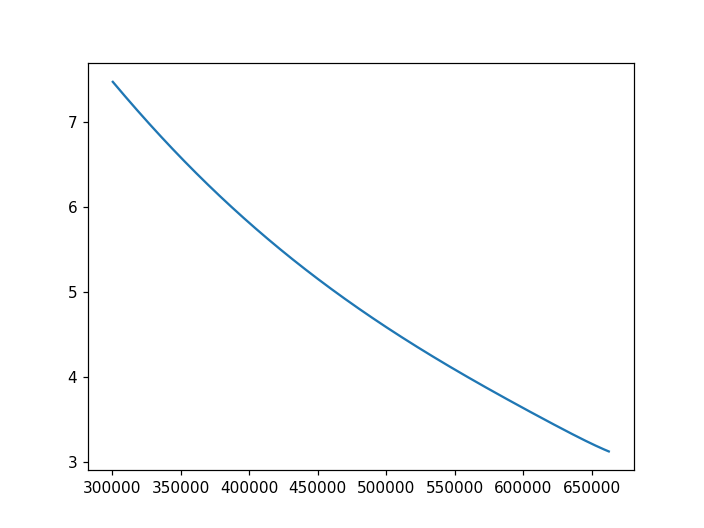

In [123]:
## TEST TEST 
P_exit_vec = np.arange(300611.4, 662379.33, 100)
shock_a = np.zeros(P_exit_vec.shape[0])
for i in range(P_exit_vec.shape[0]):
    shock_a[i] = find_shock(2.494, T_P_chamber, P_exit_vec[i], T_A_throat)
plt.plot(P_exit_vec, shock_a)

In [126]:
P_exit = P_at_alt(0)
print(P_exit)# sea level pressure 
P_chamber = P_1
expanssion_ratio_vector = np.arange(1.1, 50, .1)
num_test_ratios = expanssion_ratio_vector.shape[0]
shock_area_vector = np.zeros(num_test_ratios)
exit_area_vector = A_throat * expanssion_ratio_vector
for i in range(num_test_ratios):
    A_ratio = expanssion_ratio_vector[i]
    shock_area_vector[i] = find_shock(A_ratio, P_chamber, P_exit, A_throat)
     

101325.0


<IPython.core.display.Javascript object>


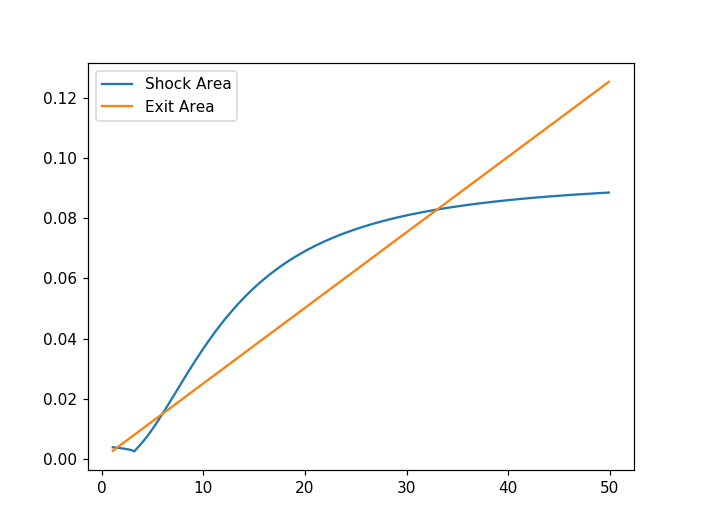

In [127]:
plt.plot(expanssion_ratio_vector, shock_area_vector, label='Shock Area')
plt.plot(expanssion_ratio_vector, exit_area_vector, label='Exit Area')
plt.legend()

# Flight Simulation 

In [128]:
def flight_sym(A_ratio, A_throat, burn_time, tot_sym_time, dt, P_chamber, T_chamber):
    A_r = A_ratio
    P_t = P_chamber
    T_t = T_chamber
    
    # initial conditions
    v_0 = 0 # [m/s] 
    y_0 = 0 # [m] initial altitude 

    # Create arrays to hold simulation veloctiy and altitude 
    v_array = np.array([v_0])
    y_array = np.array([y_0])
    t_array = np.array([0])
    thrust_array = np.array([0])


    total_simulation_time = tot_sym_time # duration of simulation, [s]

    # Initialize
    mission_time = 0 # Mission time, updated in simulation [s]
    v = v_0 # [m/s]
    y = y_0 # [m/s]
    rocket_mass = wet_mass # [kg]
    while ((mission_time < total_simulation_time) and (y >= 0)):
        if mission_time <= burn_time:       # only depricate rocket mass if mass is still burning
            mass_burned = m_dot * mission_time
            rocket_mass = wet_mass - mass_burned
        
        F_g = rocket_mass * g_grav(y) # force of gravity on rocker [N]
    
        F_d = F_drag(y, v) # drag force on rocket [N]
    
        if v < 0:          # Switch force direction if the rocket is falling
            F_d = - F_d
    
        # The thrust is zero after the burn time has finished 
        F_t = 0
        if mission_time < burn_time:
            F_t = F_thrust(m_dot, A_r, A_throat, y, P_t, T_t) # thrust force [N]
            
        
        F_net = F_t - F_d - F_g
    
        a_instant = F_net / rocket_mass 
    
        v = v + a_instant * dt        # Update velocity and position based on instant acceleration 
        y = y + v * dt
                                      # update arrays storing the simulation data
        v_array = np.append(v_array, v)
        y_array = np.append(y_array, y)
    
        mission_time += dt            # update mission time 
        t_array = np.append(t_array, mission_time)
        thrust_array = np.append(thrust_array, F_t)
    return  y_array, v_array, t_array, thrust_array 

<IPython.core.display.Javascript object>


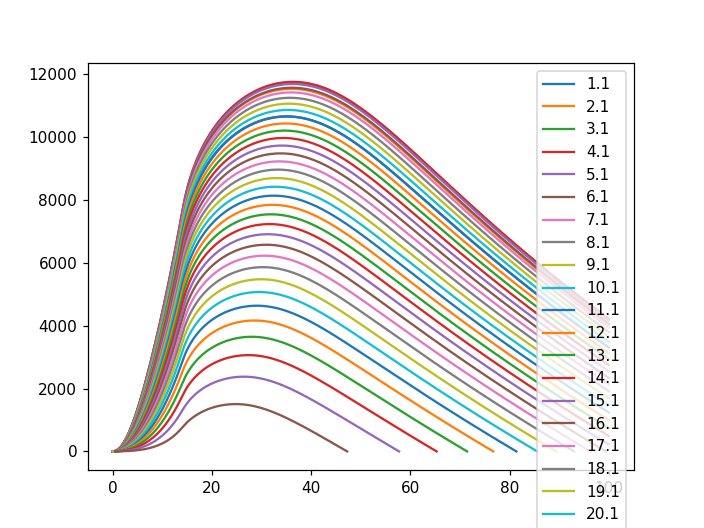

0.0
0.02040816326530612
0.04081632653061224
0.061224489795918366
0.08163265306122448
0.10204081632653061
0.12244897959183673
0.14285714285714285
0.16326530612244897
0.1836734693877551
0.20408163265306123
0.22448979591836735
0.24489795918367346
0.2653061224489796
0.2857142857142857
0.30612244897959184
0.32653061224489793
0.3469387755102041
0.3673469387755102
0.3877551020408163
0.40816326530612246
0.42857142857142855
0.4489795918367347
0.46938775510204084
0.4897959183673469
0.5102040816326531
0.5306122448979592
0.5510204081632653
0.5714285714285714
0.5918367346938775
0.6122448979591837
0.6326530612244898
0.6530612244897959
0.673469387755102
0.6938775510204082
0.7142857142857143
0.7346938775510204
0.7551020408163265
0.7755102040816326
0.7959183673469388
0.8163265306122449
0.8367346938775511
0.8571428571428571
0.8775510204081632
0.8979591836734694
0.9183673469387755
0.9387755102040817
0.9591836734693877
0.9795918367346939


In [129]:
Expansion_Ratio_Array = np.arange(1.1, 50, 1)
length_of_array = Expansion_Ratio_Array.shape[0]
Max_Alt_Array = np.zeros(length_of_array)

for i in range(length_of_array):
    A_R = Expansion_Ratio_Array[i]
    yar, var, tar, far = flight_sym(A_R, A_2, 14, 100, .01, P_1, T_1)
    Max_Alt_Array[i] = np.max(yar)
    plt.plot(tar, yar, label=str(A_R))
    print(i/length_of_array)
plt.legend()

<IPython.core.display.Javascript object>


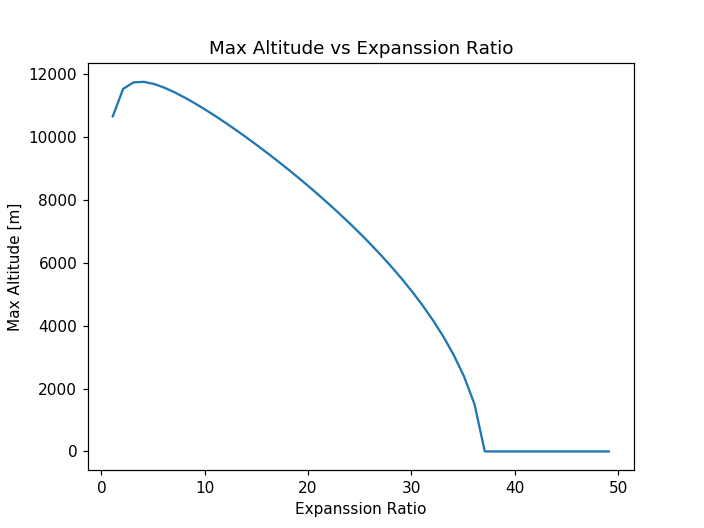

Text(0.5, 1.0, 'Max Altitude vs Expanssion Ratio')

In [130]:
plt.plot(Expansion_Ratio_Array, Max_Alt_Array)
plt.xlabel('Expanssion Ratio')
plt.ylabel('Max Altitude [m]')
plt.title('Max Altitude vs Expanssion Ratio')

In [131]:
yar, var, tar, far = flight_sym(2.4, A_2, 14, 500, .01, P_1, T_1)

<IPython.core.display.Javascript object>


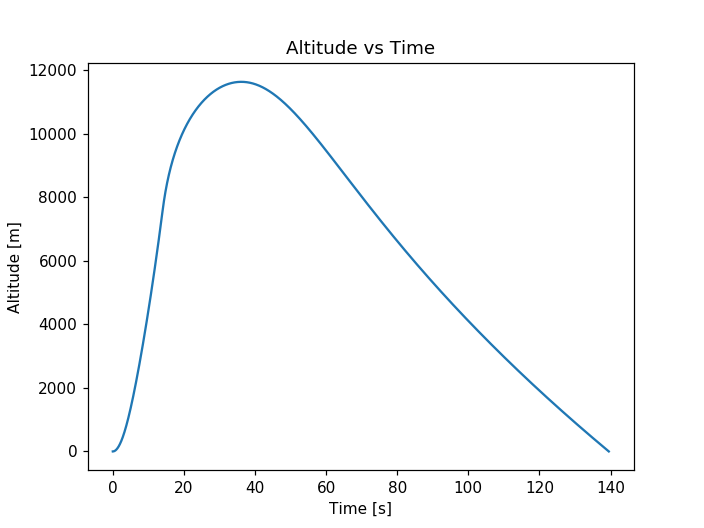

Text(0, 0.5, 'Altitude [m]')

In [132]:
plt.plot(tar, yar)
plt.title('Altitude vs Time')
plt.xlabel('Time [s]')
plt.ylabel('Altitude [m]')

<IPython.core.display.Javascript object>


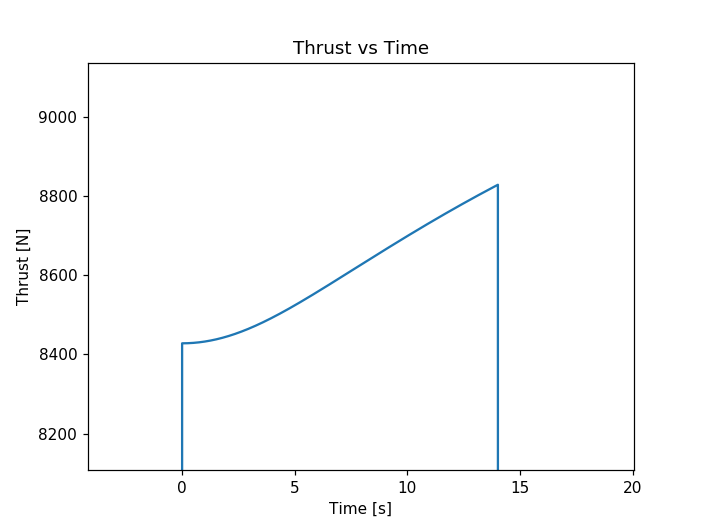

Text(0, 0.5, 'Thrust [N]')

In [133]:
plt.plot(tar, far)
plt.title('Thrust vs Time')
plt.xlabel('Time [s]')
plt.ylabel('Thrust [N]')

<IPython.core.display.Javascript object>


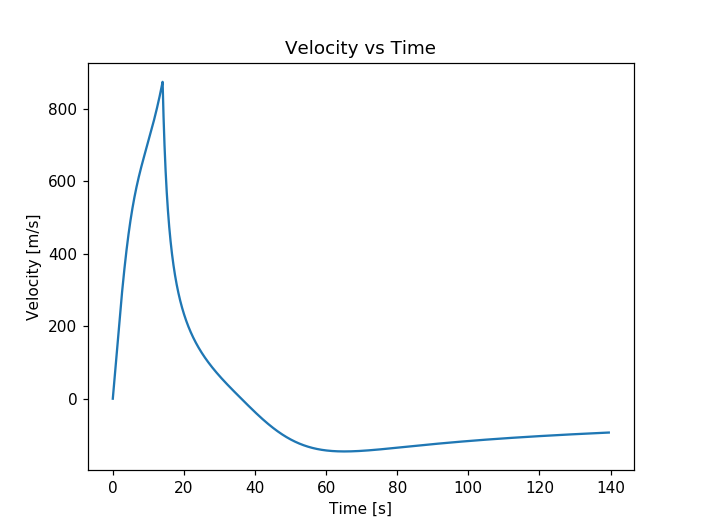

Text(0, 0.5, 'Velocity [m/s]')

In [134]:
plt.plot(tar, var)
plt.title('Velocity vs Time')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')    

<IPython.core.display.Javascript object>


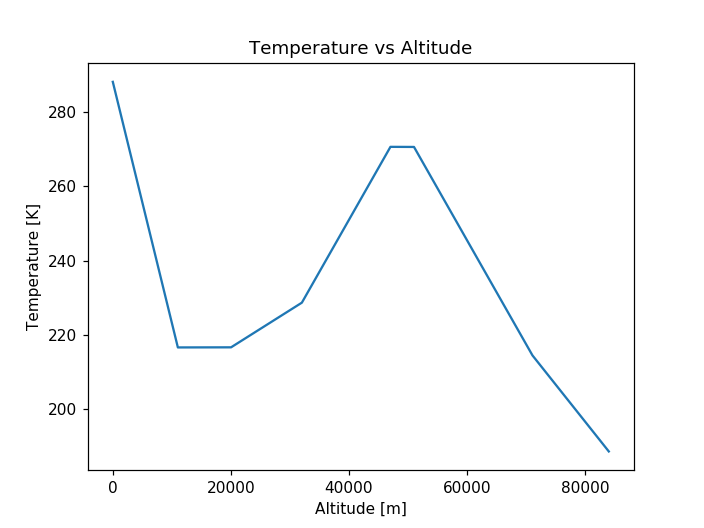

Text(0, 0.5, 'Temperature [K]')

In [135]:
tarray = np.arange(0, 84000, 1)
plt.plot(tarray, v_T_at_alt(tarray))
plt.title('Temperature vs Altitude')
plt.xlabel('Altitude [m]')
plt.ylabel('Temperature [K]')

<IPython.core.display.Javascript object>


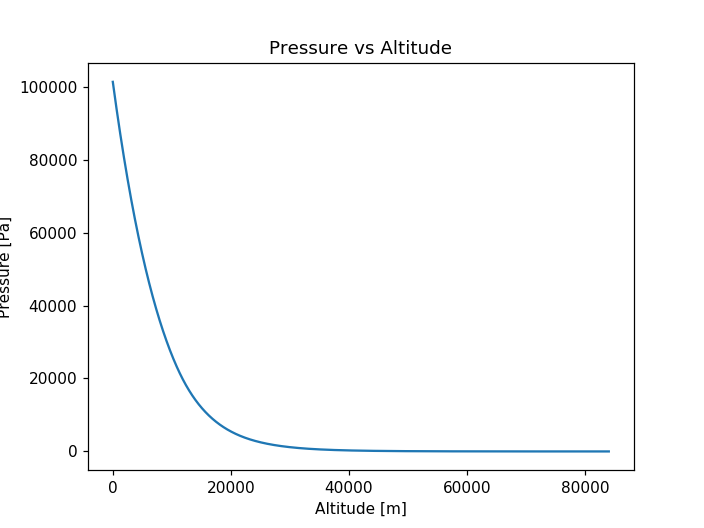

Text(0, 0.5, 'Pressure [Pa]')

In [23]:
plt.plot(tarray, v_P_at_alt(tarray))
plt.title('Pressure vs Altitude')
plt.xlabel('Altitude [m]')
plt.ylabel('Pressure [Pa]')

<IPython.core.display.Javascript object>


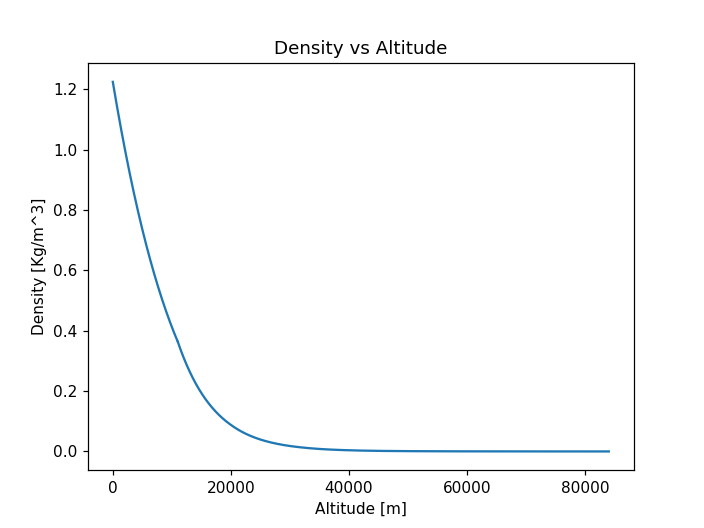

Text(0, 0.5, 'Density [Kg/m^3]')

In [24]:
plt.plot(tarray, v_density_at_alt(tarray))
plt.title('Density vs Altitude')
plt.xlabel('Altitude [m]')
plt.ylabel('Density [Kg/m^3]')

In [17]:
np.append([3, 4, 5], 4)

array([3, 4, 5, 4])